<a href="https://colab.research.google.com/github/hana-magdy/Lane-detection-using-hough-transform/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [596]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import sys

In [597]:
def Display_Images(image,grey=0):
  if grey == 0:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
  else:
    plt.imshow(image,cmap = "gray")
    plt.axis("off")
    plt.show()

In [598]:
def Load_and_GreyScale(image_name):
  img = cv2.imread(image_name)
  print("Original Image: ")
  Display_Images(img,grey=0)

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print("Original Image in grayscale: ")
  Display_Images(gray_img,grey=1)

  return img,gray_img

In [599]:
def MedianBlurrig(image,filter_size):
  blurred=cv2.medianBlur(image,filter_size)
  return blurred


In [600]:
def Canny_Edge_Detection(blurred_image,threshold1,threshold2,kernel_size):
  edge_img=cv2.Canny(blurred_image,threshold1,threshold2,apertureSize =kernel_size,L2gradient = True)
  print("edges detected with filter size = ",kernel_size)
  plt.imshow(edge_img,cmap='gray', vmin=0, vmax=255)
  plt.axis("off")
  plt.show()
  return edge_img 

In [601]:
def Region_of_intrest(edge_img):
  mask = np.zeros_like(edge_img)   
  ignore_mask_color = 255   
  imshape = edge_img.shape

  vertices = np.array([[(0,imshape[0]),(0.4*imshape[1], 0.4*imshape[0]), 
                       (0.5*imshape[1], 0.4*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)

  cv2.fillPoly(mask, vertices, 255)
  masked_image = cv2.bitwise_and(edge_img, mask)
  print("edges detected in region of intrest :")
  plt.imshow(masked_image,cmap='gray', vmin=0, vmax=255)
  plt.axis("off")
  plt.show()
  return masked_image

In [602]:
def Hough_Transform(masked_image):

   edges_index = np.where(masked_image == 255)
   height, width = masked_image.shape
   img_diagonal = np.ceil(np.sqrt(height**2 + width**2))
   
   rhos = np.arange(-img_diagonal, img_diagonal+1, 1)
   thetas = np.deg2rad(np.arange(-90,90, 1))
   H = np.zeros((len(rhos), len(thetas)))
   
   for i in range(len(edges_index[0])):
     x=edges_index[0][i]
     y=edges_index[1][i]
     for j in range(180):
       rho=y*np.cos(thetas[j])+x*np.sin(thetas[j])+img_diagonal #stop
       H[int(rho)][j]=H[int(rho)][j]+1

   return H,rhos,thetas

In [603]:
def HT_Post_Processing(H,neighbourhood_size):

    indicies = []
    H1 = np.copy(H)
    for i in range(4):
      
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (neighbourhood_size/2)) < 0: 
          min_x = 0
        else: 
          min_x = int(idx_x - (neighbourhood_size/2))
        if ((idx_x + (neighbourhood_size/2) + 1) > H.shape[1]):
           max_x = H.shape[1]
        else: 
          max_x = int(idx_x + (neighbourhood_size/2) + 1)

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (neighbourhood_size/2)) < 0:
           min_y = 0
        else:
           min_y =int( idx_y - (neighbourhood_size/2))
        if ((idx_y + (neighbourhood_size/2) + 1) > H.shape[0]):
           max_y = H.shape[0]
        else:
           max_y =int( idx_y + (neighbourhood_size/2) + 1)

        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

In [604]:
def Draw_lines(path,image,indicies,rhos,thetas):
  img_cpy =  cv2.imread(path)
  for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1500*(-b))
        y1 = int(y0 + 1500*(a))

        x2 = int(x0 - 1500*(-b))
        y2 = int(y0 - 1500*(a))

        cv2.line(img_cpy, (x1, y1), (x2, y2), (255, 0, 255), 3)

        
  for i in range (int(0.6*image.shape[0])) :
     for j in range (image.shape[1]):
       img_cpy[i][j]=image[i][j]
  Display_Images(img_cpy)

Original Image: 


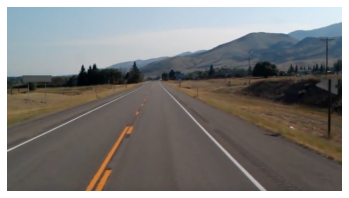

Original Image in grayscale: 


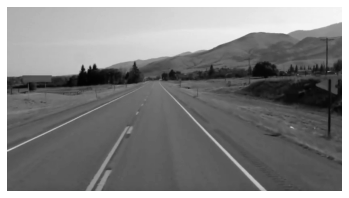

In [605]:
path = r'/content/testHough.jpg'

img,gray_img=Load_and_GreyScale(path)

Image blurred with filter size = 7


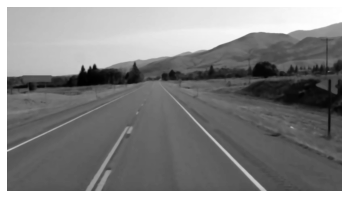

Image blurred with filter size = 5


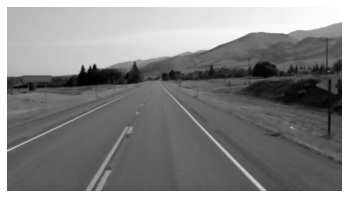

In [606]:
blurred_7=MedianBlurrig(gray_img,7)
print("Image blurred with filter size = 7")
Display_Images(blurred_7,grey=1)

blurred_5=MedianBlurrig(gray_img,5)
print("Image blurred with filter size = 5")
Display_Images(blurred_5,grey=1)

edges detected with filter size =  3


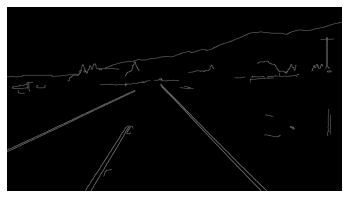

edges detected with filter size =  5


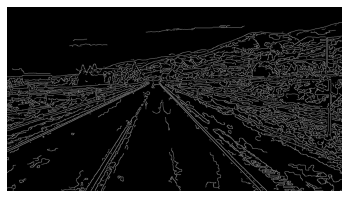

In [607]:
edge_img_3=Canny_Edge_Detection(blurred_5, 50, 150,3)

edge_img_5=Canny_Edge_Detection(blurred_5, 50, 150,5)

edges detected in region of intrest :


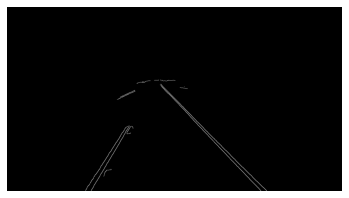

In [608]:
masked_image=Region_of_intrest(edge_img_3)

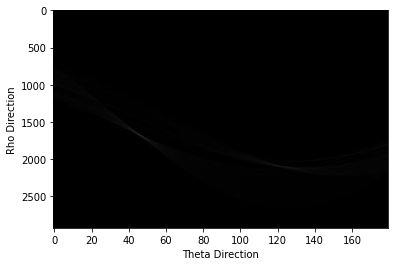

In [609]:
H,rhos,thetas=Hough_Transform(masked_image)
plt.imshow(H,cmap='gray',aspect='auto')
plt.xlabel('Theta Direction')
plt.ylabel('Rho Direction')
plt.show()

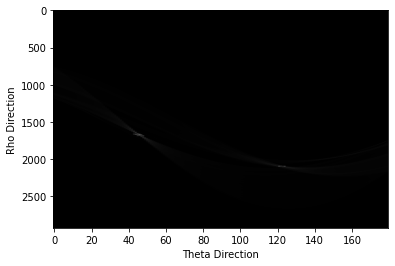

In [610]:
indicies, H_PP=HT_Post_Processing(H,3)
plt.imshow(H_PP,cmap='gray',aspect='auto')
plt.xlabel('Theta Direction')
plt.ylabel('Rho Direction')
plt.show()

if neighbourhood=3 


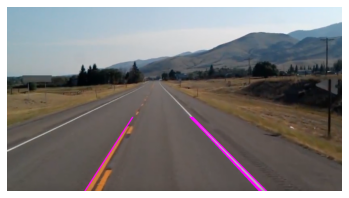

In [611]:
print("if neighbourhood=3 ")
Draw_lines(path,img,indicies,rhos,thetas)

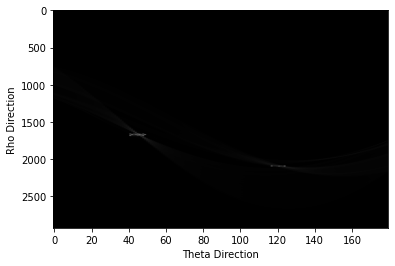

In [612]:
indicies_7, H_PP_7=HT_Post_Processing(H,7)
plt.imshow(H_PP_7,cmap='gray',aspect='auto')
plt.xlabel('Theta Direction')
plt.ylabel('Rho Direction')
plt.show()

if neighbourhood=7 


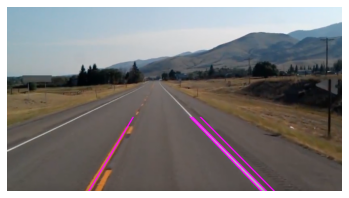

In [613]:
print("if neighbourhood=7 ")
Draw_lines(path,img,indicies_7,rhos,thetas)